## Environment Setup and Imports

In [4]:
import gc
import json
import os
import pickle
import warnings
import itertools
import time

import cudf
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from cuml.linear_model import Ridge, ElasticNet
import cupy as cp
from lightgbm import LGBMRegressor
import pandas as pd
import xgboost as xgb
import shap
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
import statsmodels.api as sm

warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/python/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compute Regression Metrics Function

In [5]:
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    explained_variance_score
)

def compute_regression_metrics(y_true, y_pred):
    """
    Computeregression metrics and return as a dictionary.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Median Absolute Error': medae,
        'Explained Variance': evs
    }
    
    return metrics

## Model Setup and Data Loading

In [6]:
#####################################
# 1. SETUP SECTION
#####################################

# Define predictor columns and target columns.
predictor_cols = [
    'bid', 'spread_minus', 'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
    'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
    'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 'non_bbo_deep_depth_add_limit',
    'non_bbo_deep_depth_remove_cancel', 'bbo_depth_imbalance_minus', 
    'non_bbo_depth_imbalance_minus', 'non_bbo_deep_depth_imbalance_minus', 
    'bbo_queue_length_immbalance_minus', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6'
]

# Additional observable features and their replicates.
ob_features = [
    'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
    'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
    'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 
    'non_bbo_deep_depth_add_limit', 'non_bbo_deep_depth_remove_cancel'
]
for feat in ob_features:
    for r in range(1, 4):
        predictor_cols.append(f'{feat}_{r}')

# Define target columns
# target_cols = ['px_imp_0', 'px_imp_1', 'px_imp_5', 'px_imp_10', 'px_imp_20']
target_cols = ['px_imp_5']

# Define file paths.
eval_pairs = [('/data/workspace_files/train_oct/oct_train1_df.parquet', '/data/workspace_files/val_oct/oct_val1_df.parquet'),
              ('/data/workspace_files/train_oct/oct_train2_df.parquet', '/data/workspace_files/val_oct/oct_val2_df.parquet'),
              ('/data/workspace_files/train_oct/oct_train3_df.parquet', '/data/workspace_files/val_oct/oct_val3_df.parquet'),
              ('/data/workspace_files/train_oct/oct_train4_df.parquet', '/data/workspace_files/val_oct/oct_val4_df.parquet'),
              ('/data/workspace_files/train_nov/nov_train5_df.parquet', '/data/workspace_files/val_nov/nov_val5_df.parquet'),
              ('/data/workspace_files/train_nov/nov_train6_df.parquet', '/data/workspace_files/val_nov/nov_val6_df.parquet'),
              ('/data/workspace_files/train_nov/nov_train7_df.parquet', '/data/workspace_files/val_nov/nov_val7_df.parquet')]


## Data Loading for SHAP Analysis

In [7]:
X_train = pd.read_parquet('/data/workspace_files/val_nov/last_day_nov_df.parquet', columns=predictor_cols)
y_train = pd.read_parquet('/data/workspace_files/val_nov/last_day_nov_df.parquet', columns=['px_imp_20'])
y_train = np.abs(y_train)

## Model Training for SHAP Analysis

In [22]:
gbt_sklearn_perm = LGBMRegressor(boosting_type='gbdt', n_estimators=100, max_depth=20,
                          learning_rate=0.05, num_leaves=31, device='cpu', random_state=42)
gbt_sklearn_perm.fit(X_train, y_train)

# Create an explainer based on your model and training data.
# If your model is tree-based, you can use TreeExplainer.
explainer = shap.TreeExplainer(gbt_sklearn_perm, data=X_train)

# Compute SHAP values for your dataset.
shap_values_gbt = explainer.shap_values(X_train, check_additivity=False)

with open('/data/workspace_files/Metrics/GBT/gbt_shap_full_perm.pkl', 'wb') as file:
    pickle.dump(shap_values_gbt, file)

with open('/data/workspace_files/Models/GBT/gbt_sklearn_perm.pkl', 'wb') as file:
    pickle.dump(gbt_sklearn_perm, file)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 1596130, number of used features: 51
[LightGBM] [Info] Start training from score 0.000115


 18%|====                | 280721/1596130 [05:23<25:13]       

In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train)

boost_params = {
    'max_depth': 5,
    'learning_rate': 0.05,
    'min_child_weight': 1,
    'subsample': 1.0,
    'tree_method': 'hist',
    'n_jobs': -1,
    'booster': 'gbtree',
    'device': 'cpu',
    'objective': 'reg:squarederror',
    'seed': 42
}

booster = xgb.train(boost_params, dtrain, num_boost_round=100)

explainer = shap.TreeExplainer(booster, data=X_train)

# Compute SHAP values for your dataset.
shap_values_xgb = explainer.shap_values(X_train, check_additivity=False)

with open('/data/workspace_files/Metrics/XGB/xgb_shap_full.pkl', 'wb') as file:
    pickle.dump(shap_values_xgb, file)

100%|===================| 1595836/1596130 [35:00<00:00]       

In [24]:
rf_sklearn = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt', max_leaf_nodes=50)
rf_sklearn.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf_sklearn, data=X_train)

# Compute SHAP values for your dataset.
shap_values_rf = explainer.shap_values(X_train, check_additivity=False)

with open('/data/workspace_files/Metrics/RF/rf_shap_full.pkl', 'wb') as file:
    pickle.dump(shap_values_rf, file)

/opt/python/envs/py311/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
100%|===================| 1595963/1596130 [42:05<00:00]       

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_scaled, columns=X_train.columns, index=X_train.index)

ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

explainer = shap.LinearExplainer(ridge, X_train)

# Compute SHAP values for your data of interest.
shap_values_ridge = explainer.shap_values(X_train)

with open('/data/workspace_files/Metrics/Ridge/ridge_shap_full.pkl', 'wb') as file:
    pickle.dump(shap_values_ridge, file)

### Plotting SHAP and Partial Dependence Visualizations

In [8]:
with open('/data/workspace_files/Metrics/GBT/gbt_shap_full.pkl', 'rb') as file:
    shap_gbt = pickle.load(file)

with open('/data/workspace_files/Metrics/XGB/xgb_shap_full.pkl', 'rb') as file:
    shap_xgb = pickle.load(file)

with open('/data/workspace_files/Metrics/RF/rf_shap_full.pkl', 'rb') as file:
    shap_rf = pickle.load(file)

#### GBT

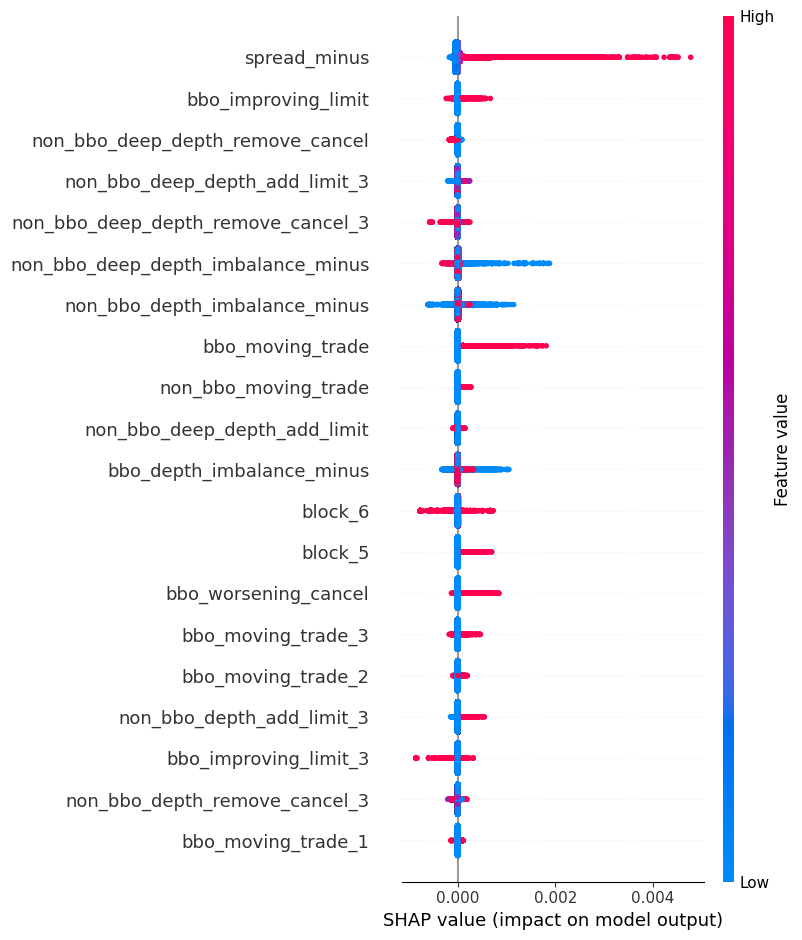

In [12]:
shap.summary_plot(shap_gbt, X_train)

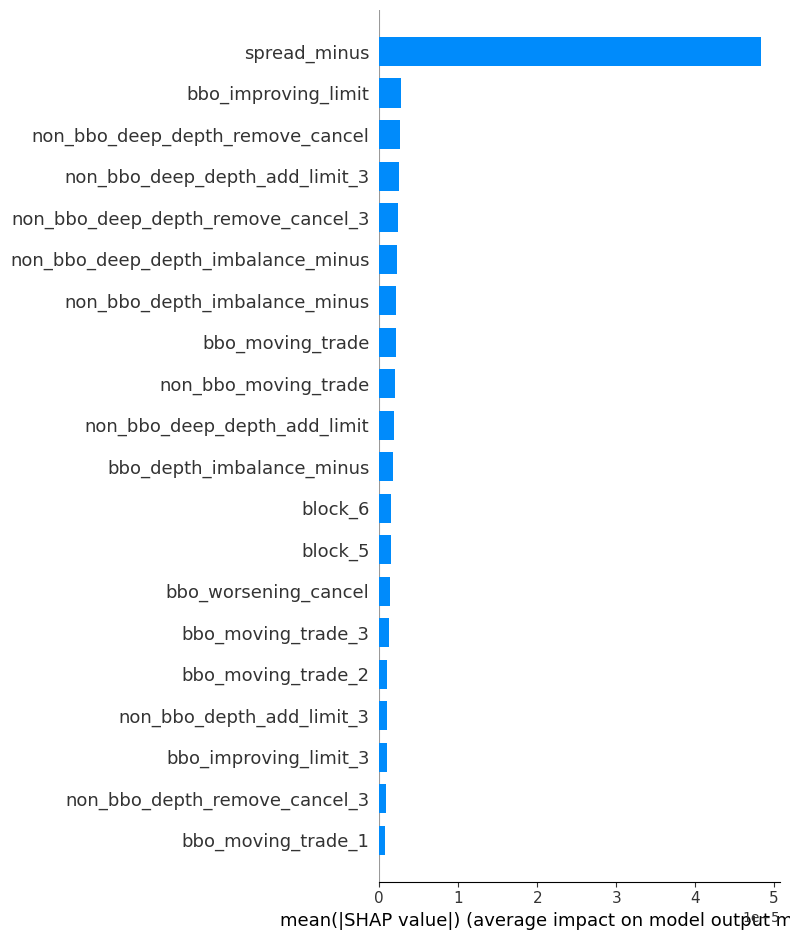

In [13]:
shap.summary_plot(shap_gbt, X_train, plot_type="bar")

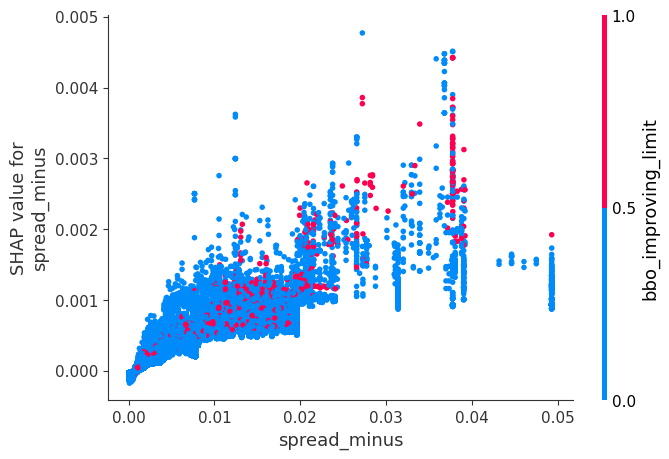

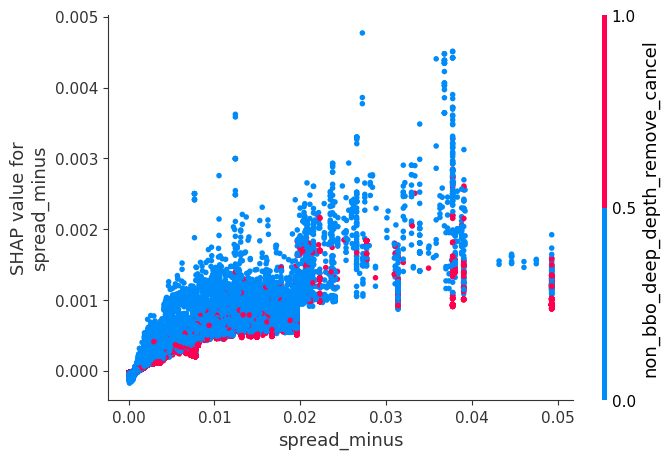

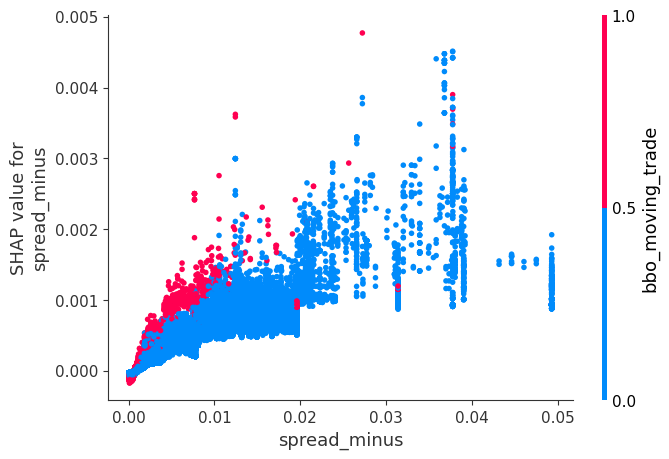

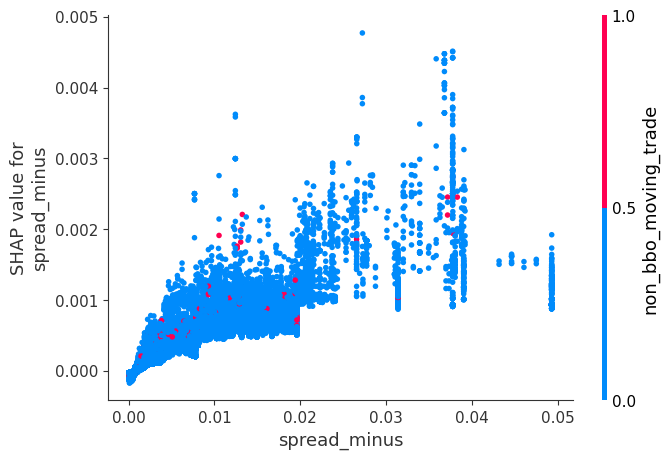

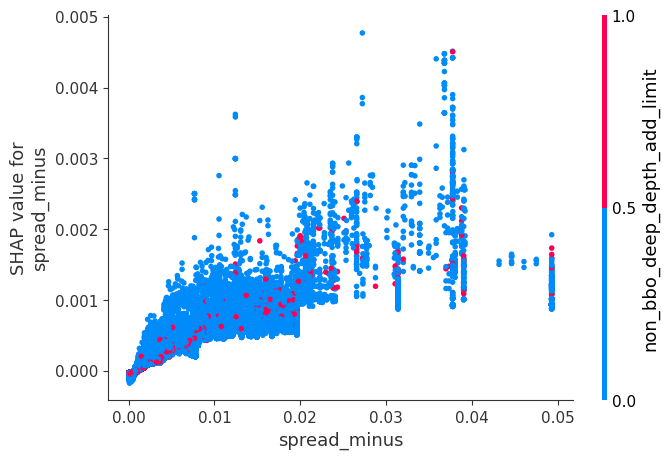

In [11]:
most_important_classes = [4, 11, 2, 3, 10]

for i in most_important_classes:
    shap.dependence_plot(1, shap_gbt, X_train, interaction_index=i, x_jitter=0.2)

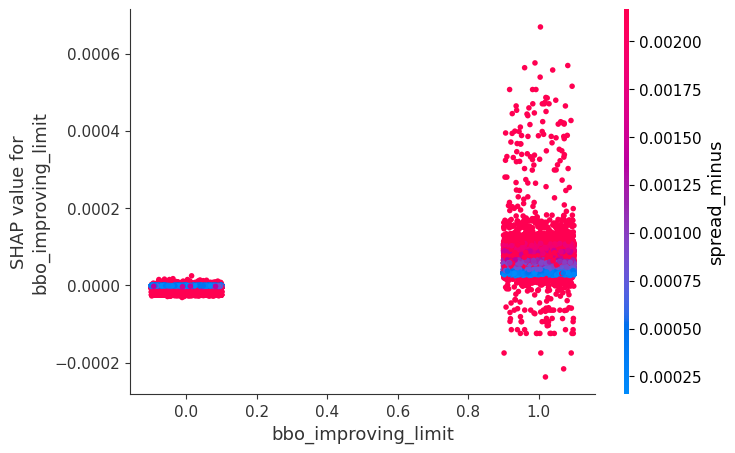

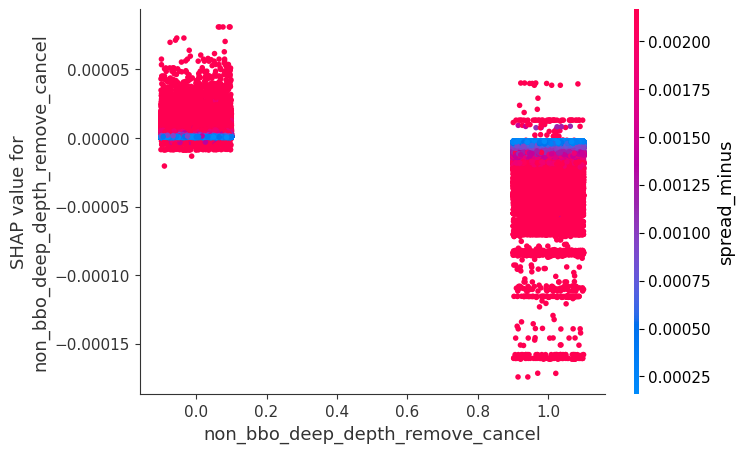

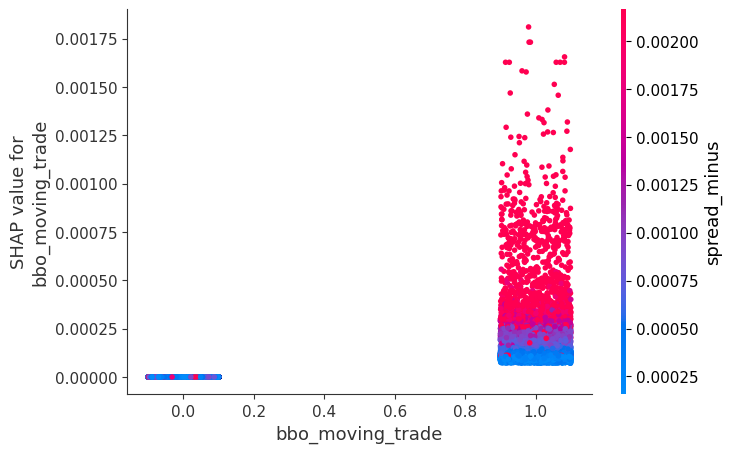

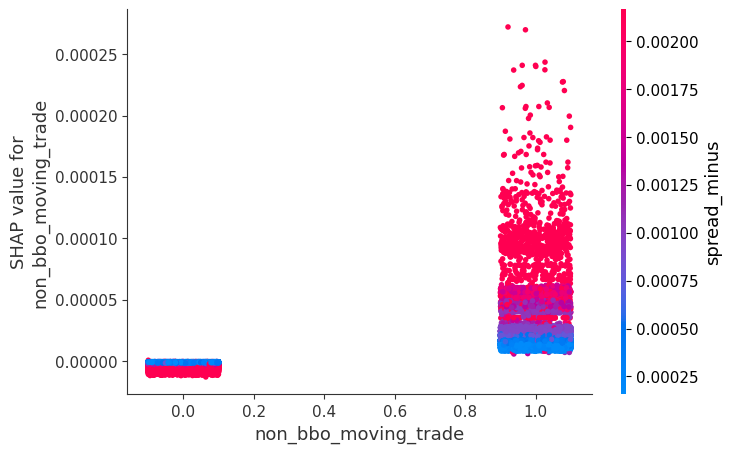

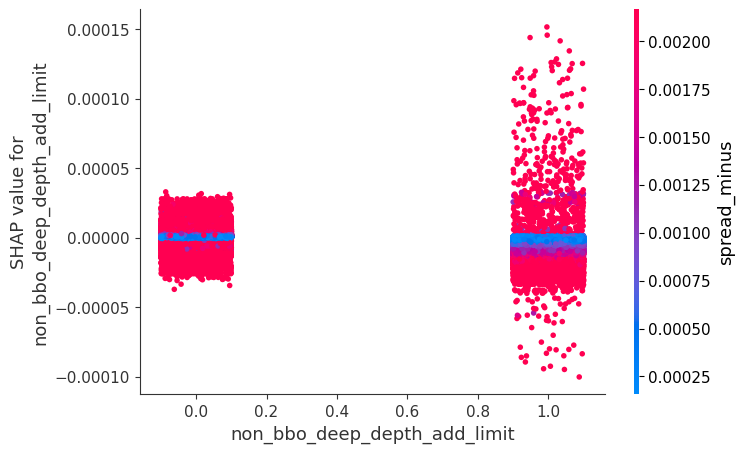

In [12]:
for i in most_important_classes:
    shap.dependence_plot(i, shap_gbt, X_train, interaction_index=1, x_jitter=0.2)

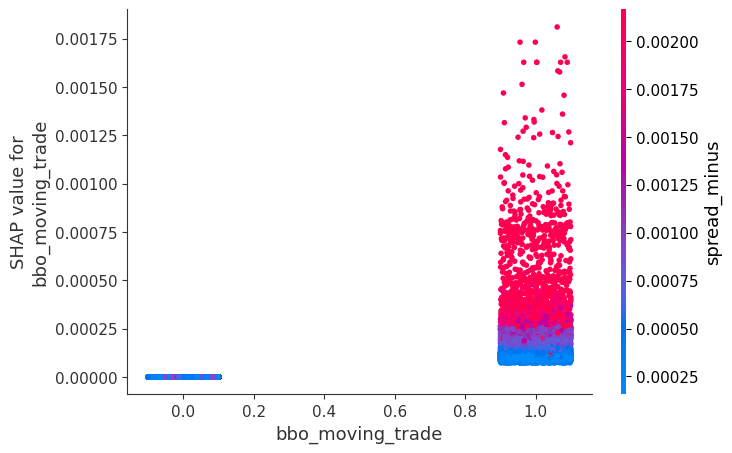

In [21]:
shap.dependence_plot(2, shap_gbt, X_train, interaction_index='auto', x_jitter=0.2)

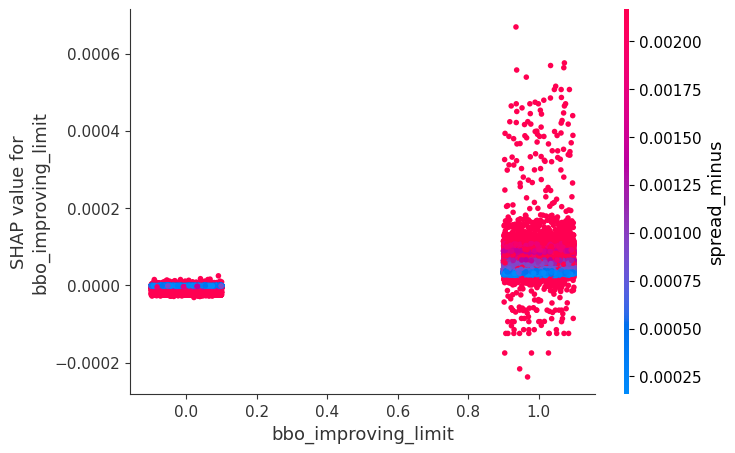

In [23]:
shap.dependence_plot(4, shap_gbt, X_train, interaction_index='auto', x_jitter=0.2)

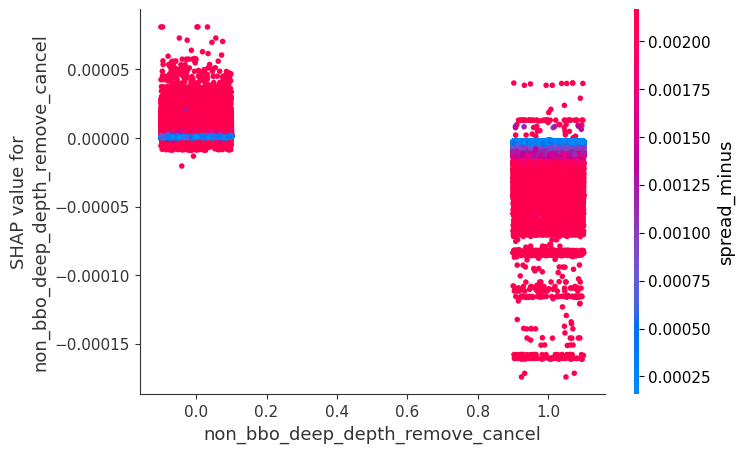

In [24]:
shap.dependence_plot(11, shap_gbt, X_train, interaction_index='auto', x_jitter=0.2)

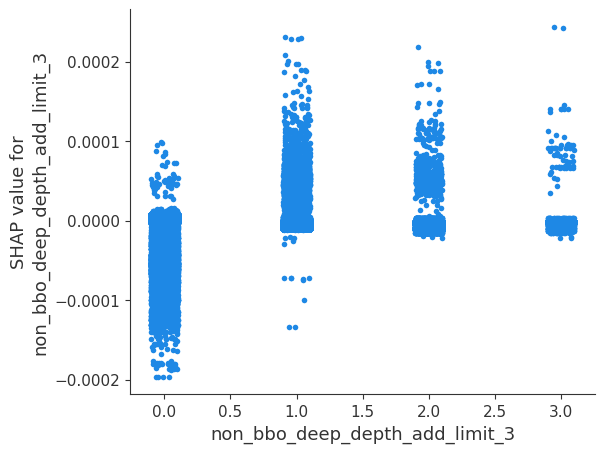

In [9]:
shap.dependence_plot(47, shap_gbt, X_train, interaction_index=None, x_jitter=0.2)

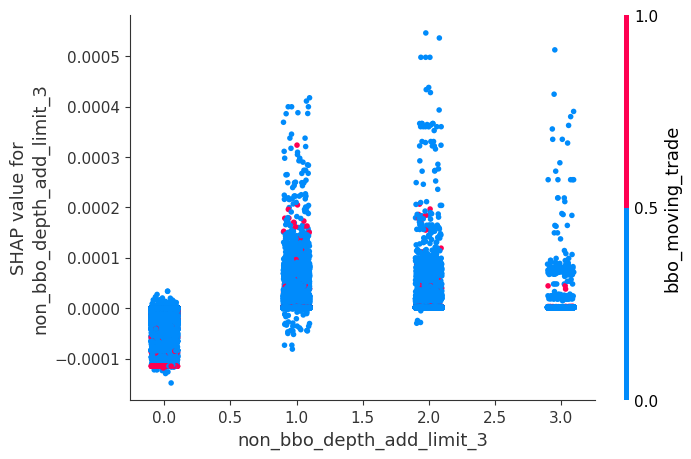

In [16]:
shap.dependence_plot(41, shap_gbt, X_train, interaction_index=2, x_jitter=0.2)

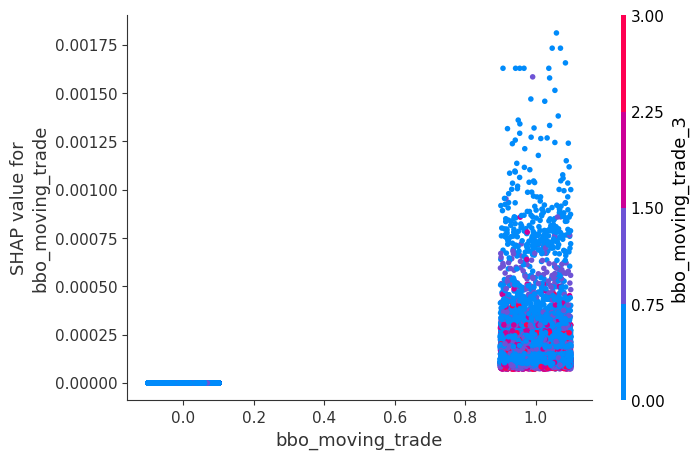

In [47]:
shap.dependence_plot(2, shap_gbt, X_train, interaction_index=23, x_jitter=0.2)

In [17]:
for i, col in enumerate(predictor_cols):
    print(i, col)

0 bid
1 spread_minus
2 bbo_moving_trade
3 non_bbo_moving_trade
4 bbo_improving_limit
5 bbo_worsening_cancel
6 bbo_depth_add_limit
7 bbo_depth_remove_cancel
8 non_bbo_depth_add_limit
9 non_bbo_depth_remove_cancel
10 non_bbo_deep_depth_add_limit
11 non_bbo_deep_depth_remove_cancel
12 bbo_depth_imbalance_minus
13 non_bbo_depth_imbalance_minus
14 non_bbo_deep_depth_imbalance_minus
15 bbo_queue_length_immbalance_minus
16 block_2
17 block_3
18 block_4
19 block_5
20 block_6
21 bbo_moving_trade_1
22 bbo_moving_trade_2
23 bbo_moving_trade_3
24 non_bbo_moving_trade_1
25 non_bbo_moving_trade_2
26 non_bbo_moving_trade_3
27 bbo_improving_limit_1
28 bbo_improving_limit_2
29 bbo_improving_limit_3
30 bbo_worsening_cancel_1
31 bbo_worsening_cancel_2
32 bbo_worsening_cancel_3
33 bbo_depth_add_limit_1
34 bbo_depth_add_limit_2
35 bbo_depth_add_limit_3
36 bbo_depth_remove_cancel_1
37 bbo_depth_remove_cancel_2
38 bbo_depth_remove_cancel_3
39 non_bbo_depth_add_limit_1
40 non_bbo_depth_add_limit_2
41 non_bbo_

#### XGB

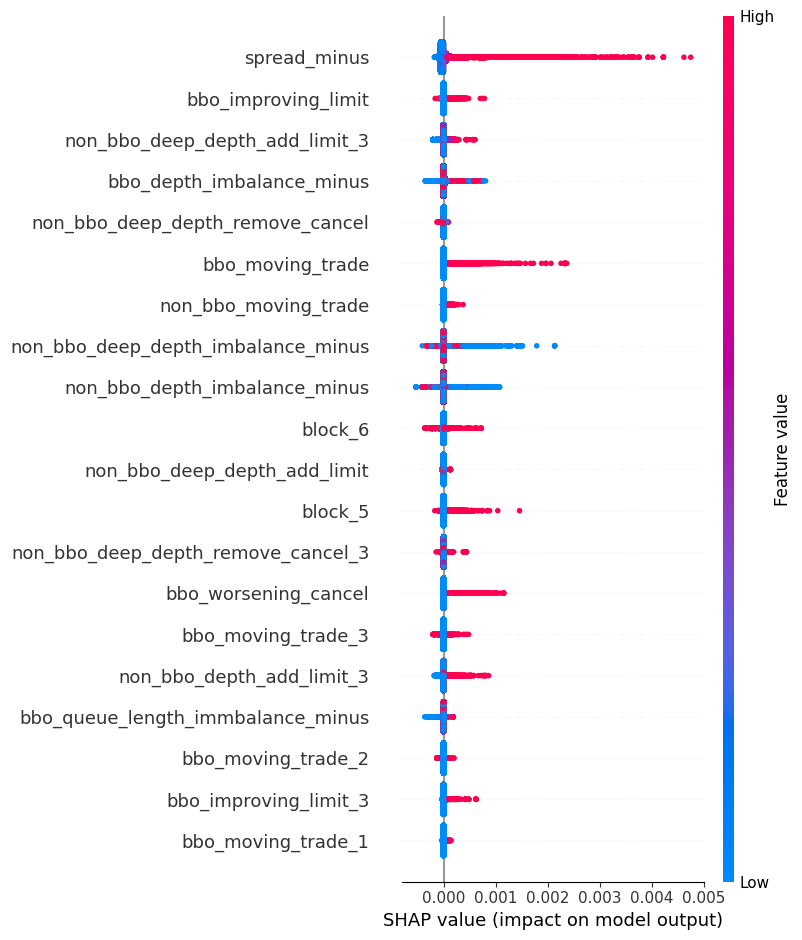

In [38]:
shap.summary_plot(shap_xgb, X_train)

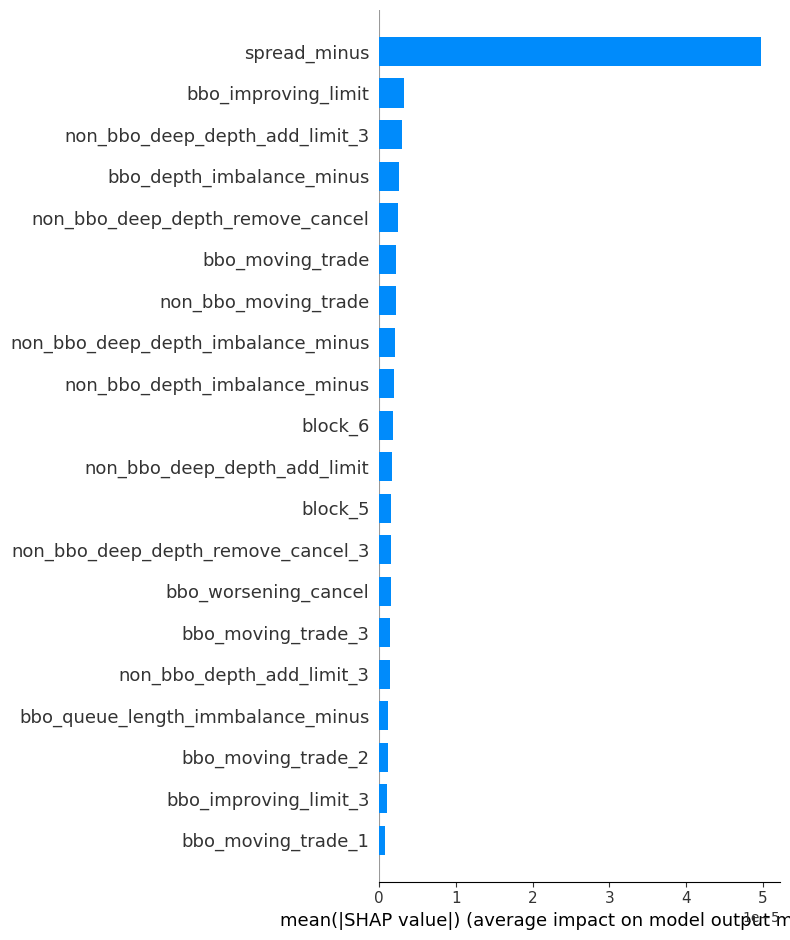

In [39]:
shap.summary_plot(shap_xgb, X_train, plot_type="bar")

#### Random Forest

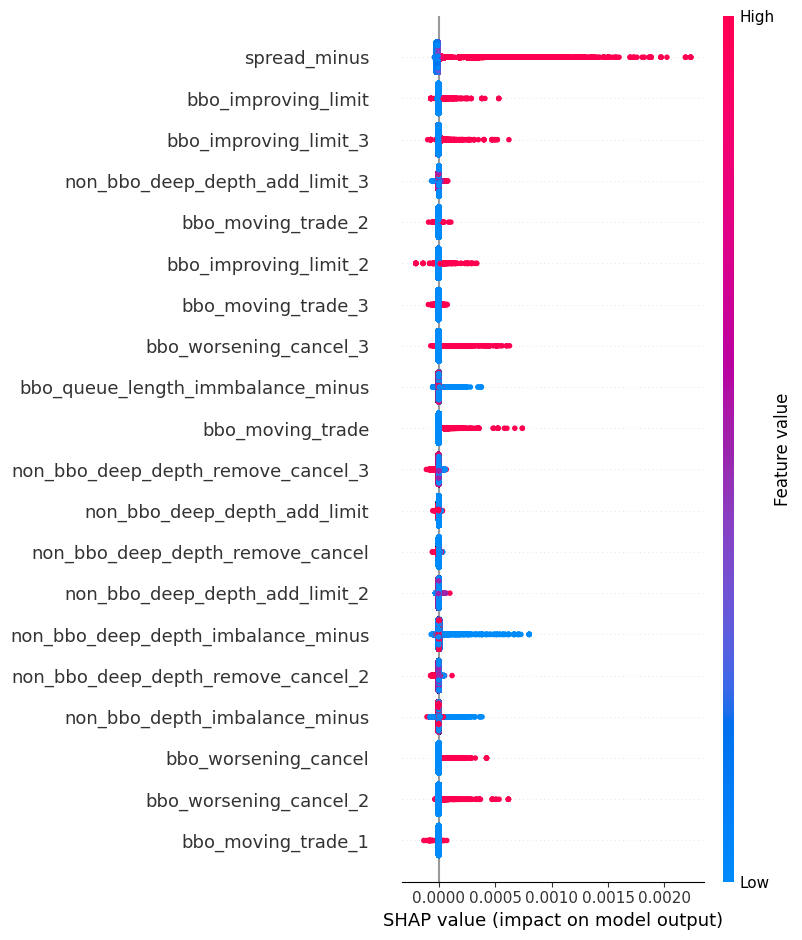

In [40]:
shap.summary_plot(shap_rf, X_train)

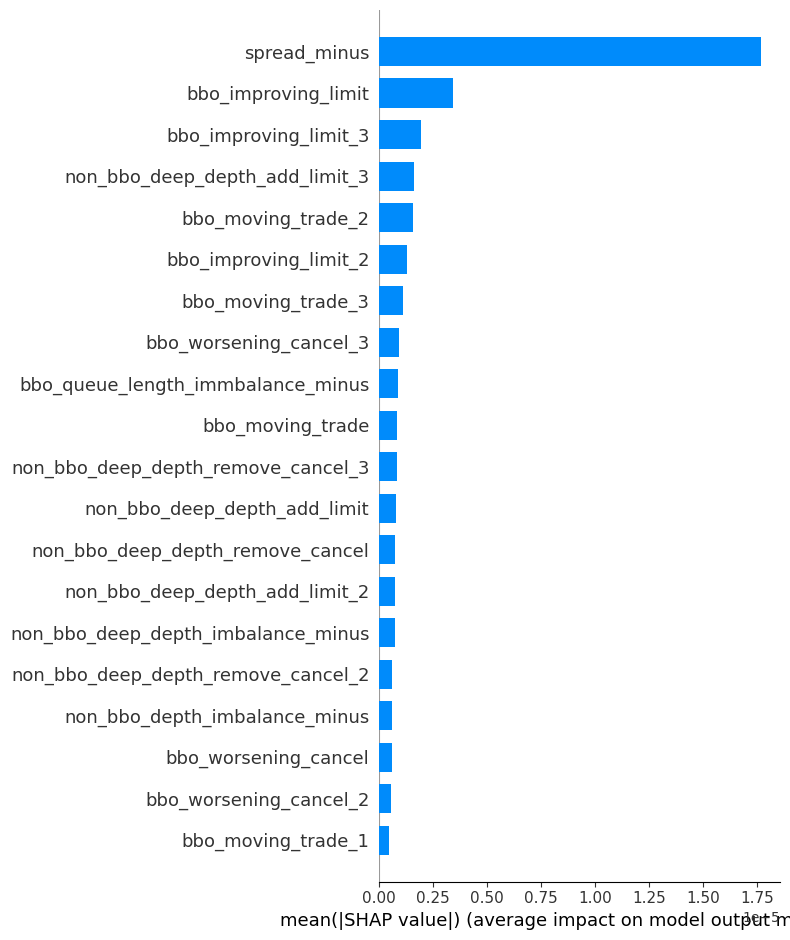

In [41]:
shap.summary_plot(shap_rf, X_train, plot_type="bar")

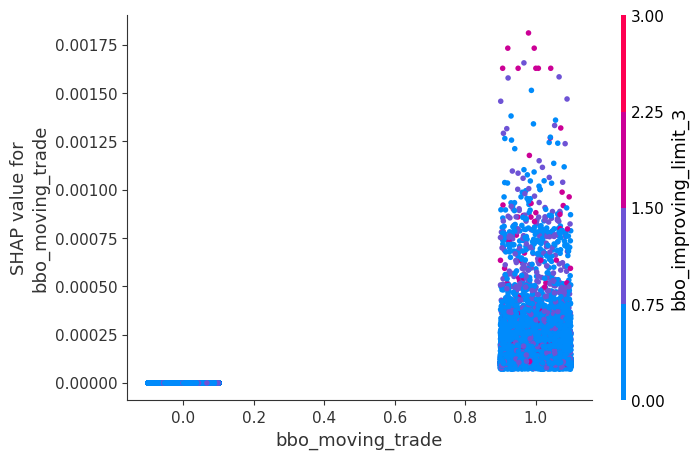

In [50]:
shap.dependence_plot(2, shap_gbt, X_train, interaction_index=29, x_jitter=0.2)

### Partial Dependence Plots

In [10]:
with open('/data/workspace_files/Models/GBT/sklearn_model_gbt.pkl.pkl', 'rb') as file:
    gbt_sklearn = pickle.load(file)

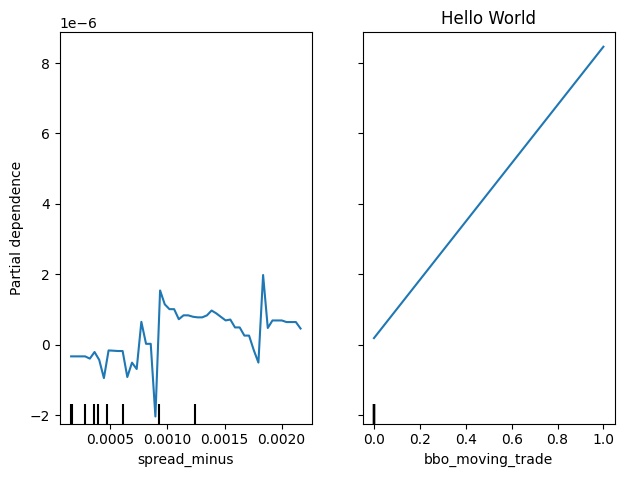

In [14]:

features = [1, 2]  # Alternatively, you can use feature names if X is a DataFrame

# Create partial dependence plots
display = PartialDependenceDisplay.from_estimator(
    gbt_sklearn, X_train, features, kind="average", grid_resolution=50, n_jobs=-1
)

plt.tight_layout()
plt.title('Hello World')
plt.show()

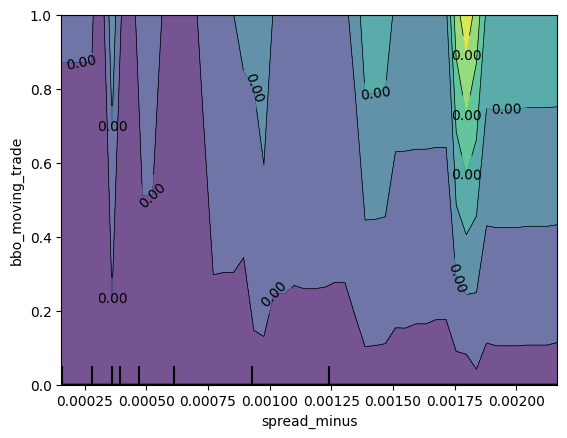

In [11]:
PartialDependenceDisplay.from_estimator(gbt_sklearn, X_train, [(1, 2)], grid_resolution=50)
plt.show()

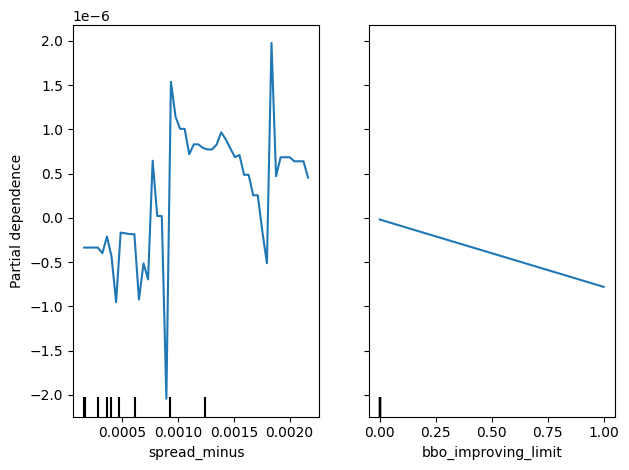

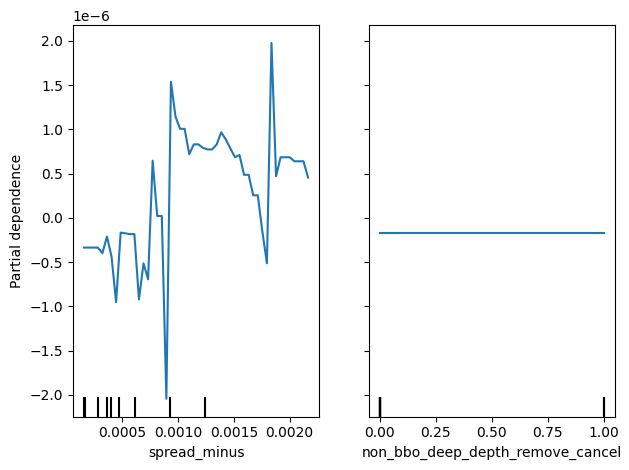

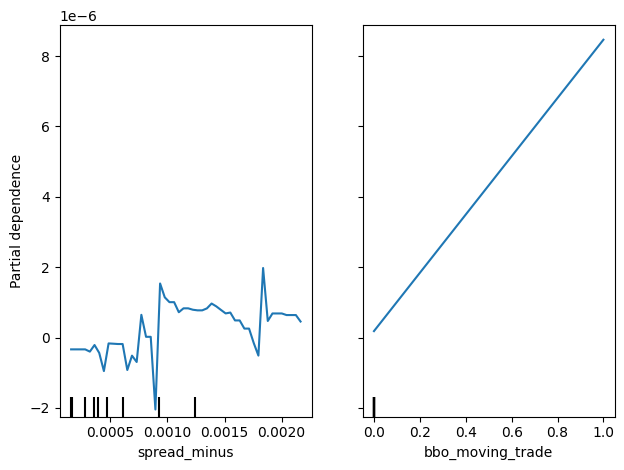

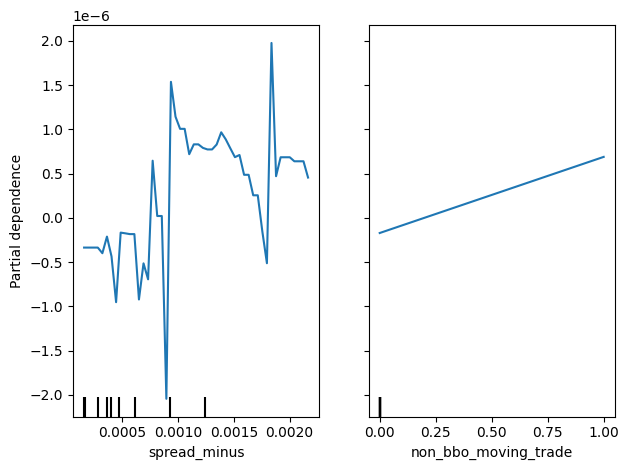

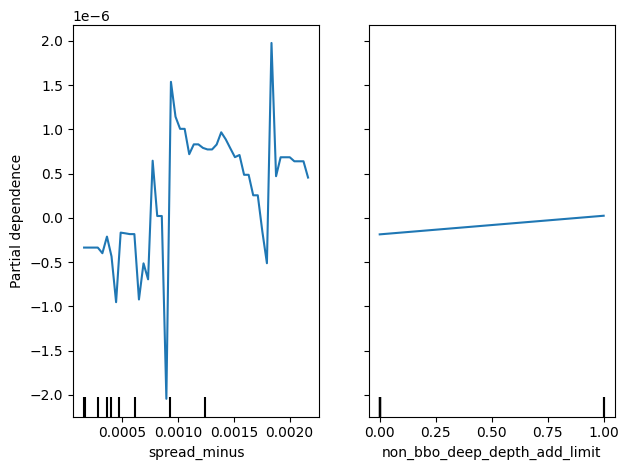

In [16]:
most_important_classes = [4, 11, 2, 3, 10]

for i in most_important_classes:
    
    features = [1, i] 

    # Create partial dependence plots
    display = PartialDependenceDisplay.from_estimator(
        gbt_sklearn, X_train, features, kind="average", grid_resolution=50, n_jobs=-1
    )

    plt.tight_layout()
    plt.show()

### Permutation Importance Analysis

In [11]:
tickers = ['JPM', 'HPE', 'LNT', 'LULU', 'CCL', 'BBIO', 'NTNX', 'KO', 'NFE', 'MVST']
days = ['02', '03', '04']

perm_test = pd.DataFrame()

for ticker in tickers:
    for day in days:
        df = pd.read_parquet(f'/data/workspace_files/test_dec/{ticker}/{ticker}-202412{day}-df.parquet')
        perm_test = pd.concat([perm_test, df])

perm_test.to_parquet('/data/workspace_files/test_dec/perm_test_df.parquet')

In [12]:
X_test = perm_test[predictor_cols]
y_test = perm_test['px_imp_5']

# Compute permutation importance on the test set
result = permutation_importance(
    gbt_sklearn, X_test, y_test, 
    scoring='r2',  
    n_repeats=10,   # Number of times to permute a feature
    random_state=42
)

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_STD': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

importance_df

,Feature,Importance_Mean,Importance_STD
1,spread_minus,8.632509e-02,2.634387e-04
0,bid,8.125082e-02,9.241452e-04
2,bbo_moving_trade,3.530698e-02,2.015979e-04
4,bbo_improving_limit,2.216066e-02,1.440392e-04
15,bbo_queue_length_immbalance_minus,2.154248e-02,1.963666e-04
12,bbo_depth_imbalance_minus,1.001809e-02,2.692153e-04
14,non_bbo_deep_depth_imbalance_minus,4.179415e-03,2.077785e-04
5,bbo_worsening_cancel,3.720112e-03,7.812656e-05
3,non_bbo_moving_trade,2.534538e-03,5.913645e-05
23,bbo_moving_trade_3,1.188237e-03,3.184912e-05


In [13]:
importance_df.to_parquet('/data/workspace_files/Metrics/General/importance.parquet')

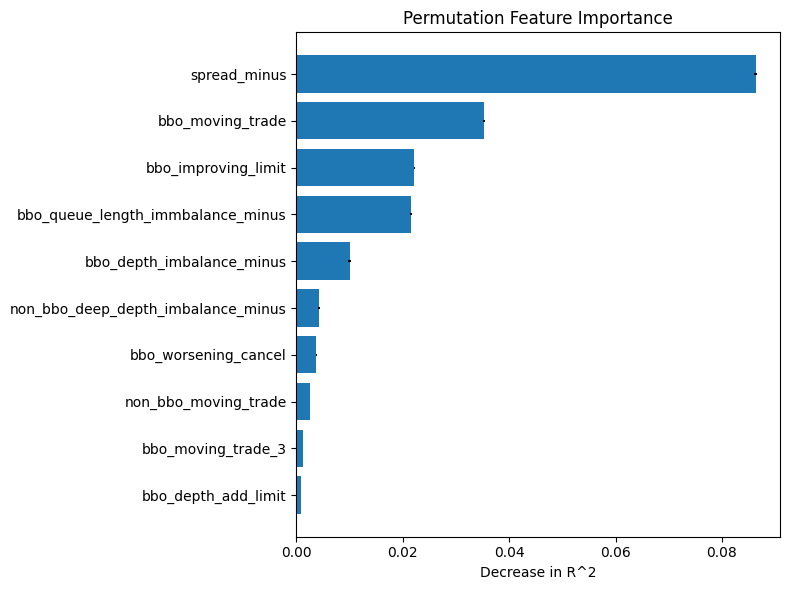

In [20]:
# importance_df = importance_df.drop(0)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'].iloc[:10], importance_df['Importance_Mean'].iloc[:10], xerr=importance_df['Importance_STD'].iloc[:10])
plt.xlabel("Decrease in R^2")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.savefig("perm_importance_px5.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
with open('/data/workspace_files/Metrics/Enet/metrics_final_model_enet_dec2.json', 'rb') as file:
    met = pickle.load(file)

In [24]:
mod.coef_

array([ 9.13689964e-06, 2.77423714e-06, -1.73799530e-06, 4.87386217e-07,
 1.26719706e-07, 7.77161307e-07, 4.43962581e-07, 4.25265311e-07,
 4.66758891e-07, 4.95809184e-07, 5.89599558e-07, 5.53880277e-07,
 -6.98802969e-06, -2.57356725e-06, 3.63588520e-07, -9.45911374e-06,
 1.41643280e-07, 1.20947144e-07, 2.39224474e-07, 1.70303437e-07,
 7.01071622e-07, -6.36942873e-07, -5.97628481e-07, 1.89784132e-07,
 -8.75358402e-08, 6.30197745e-08, 9.19881013e-07, -5.18878101e-08,
 -6.01938280e-07, -3.57562164e-07, -7.82618613e-08, 4.70956801e-07,
 2.73003133e-08, -1.87039312e-07, -1.03872235e-07, 4.03388702e-07,
 -8.08999734e-08, -8.06499491e-08, 2.38027260e-07, -1.82179729e-07,
 3.25970964e-08, 4.11678798e-07, -1.60780423e-07, 2.91017618e-08,
 1.77300582e-07, -2.67392954e-07, 7.32272810e-08, 3.90742420e-07,
 -2.71105425e-07, 1.02678422e-07, 1.94323742e-07])